In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import numpy as np
import os
import fnmatch
import time
import func
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from params import dresden_images_root, train_csv_path, unseen_csv_path, unseen_root

In [4]:
warnings.filterwarnings("ignore")

if not os.path.exists(unseen_root):
    os.makedirs(unseen_root)

train_db = pd.read_csv(train_csv_path)
unseen_db = pd.read_csv(unseen_csv_path)
real_model_list = train_db['brand_model']
unseen_model_list = unseen_db['brand_model']

# How many model in my dataset, real are trained models, test are unseen models
real_model = np.unique(real_model_list) 
unseen_model = np.unique(unseen_model_list) 
print("real models: {}".format(', '.join(real_model)))
print("test models: {}\n".format(', '.join(unseen_model)))

if not os.path.exists(unseen_root):
    os.makedirs(unseen_root)
    
    time.sleep(0.3)
    for model in unseen_model:
        tmp_list = fnmatch.filter(unseen_db['path'], model + '*')
        print("{} in test set: {}.".format(model, len(tmp_list)))
        time.sleep(0.1)
        func.patch(model, tmp_list, '.', patches_root=unseen_root)
else:
    for model in unseen_model:
        tmp_list = fnmatch.filter(unseen_db['path'], model + '*')
        print("{} in test set: {}.".format(model, len(tmp_list)))
    print('\nData is ready!')

real models: Canon_Ixus70, Nikon_D200, Olympus_mju-1050SW
test models: Agfa_DC-830i, Canon_Ixus55, Canon_PowerShotA640, Nikon_D70, Sony_DSC-W170

Agfa_DC-830i in test set: 363.
Canon_Ixus55 in test set: 224.
Canon_PowerShotA640 in test set: 188.
Nikon_D70 in test set: 369.
Sony_DSC-W170 in test set: 405.

Data is ready!


Found 38725 images belonging to 5 classes.

It tooks 39 seconds

index are predictions, columns are ground truth



,Canon_Ixus70,Nikon_D200,Olympus_mju-1050SW
Agfa_DC-830i,985,566,2
Canon_Ixus55,911,0,5
Canon_PowerShotA640,744,11,0
Nikon_D70,346,1054,108
Sony_DSC-W170,1324,325,19


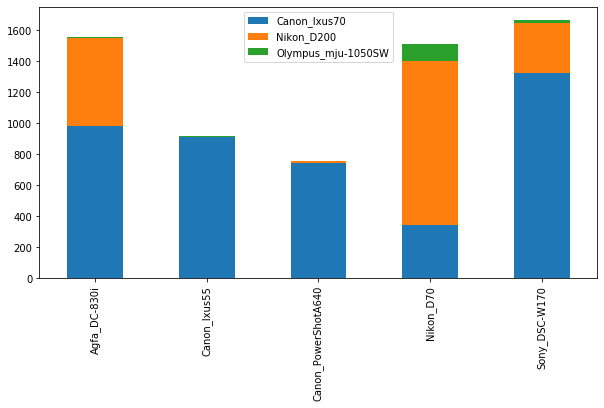

In [5]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('./model.h5')
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)
# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./unseen/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# generate a histogram, which for every unseen models, how many imgs are classified.
hist, conf, labels = func.evaluate(unseen_model, test_generator, model, index=unseen_model, columns=real_model, title=None, num_batch=100)

Test models on these 5 cameras:
- **Agfa_DC-830i** (different brand, same content)
- **Canon_Ixus55** (same brand, same content)
- **Canon_Powershot64** (same brand, different content)
- **Nikon_D70** (same brand, same content)
- **Sony_W170** (different brand, different content)

In [6]:
labels = np.hstack((labels))
labels = np.asarray([unseen_model[label] for label in labels])
conf = np.vstack((conf))

dc = {'labels': labels}
for i in range(len(real_model)):
    dc[real_model[i]] = [c[i] for c in conf]

The mean of the confidence is: 



,Canon_Ixus70,Nikon_D200,Olympus_mju-1050SW
labels,,,
Agfa_DC-830i,0.633312,0.364757,0.001931
Canon_Ixus55,0.994561,0.000110,0.005328
Canon_PowerShotA640,0.983849,0.015778,0.000372
Nikon_D70,0.235740,0.685221,0.079039
Sony_DSC-W170,0.784462,0.199197,0.016340


The standard deviation of the confidence is: 



,Canon_Ixus70,Nikon_D200,Olympus_mju-1050SW
labels,,,
Agfa_DC-830i,0.447792,0.447705,0.028944
Canon_Ixus55,0.067955,0.001895,0.067403
Canon_PowerShotA640,0.115477,0.114711,0.007469
Nikon_D70,0.374579,0.402532,0.199605
Sony_DSC-W170,0.373692,0.366701,0.089725


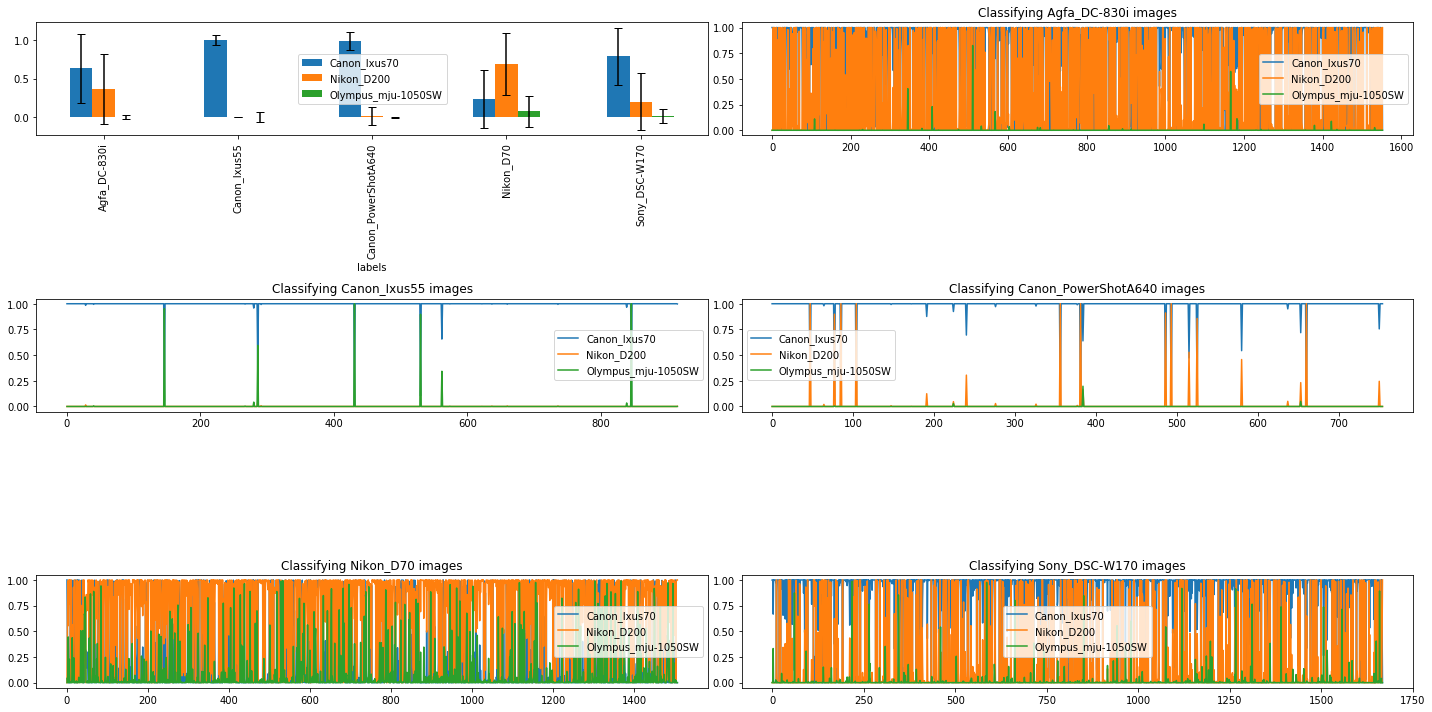

In [8]:
df = pd.DataFrame(dc)
print('The mean of the confidence is: \n')
mean = df.groupby(['labels']).mean()
display(mean)
print('The standard deviation of the confidence is: \n')
error = df.groupby(['labels']).std()
display(error)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
mean.plot.bar(yerr=error, ax=axes[0,0], capsize=4)

# for all the images' real label is a certain camera, for example Canon_Ixus70, 
# how does these images are classified ? The magnitude of the histogram indicate how
# sure is the model classified the image as one camera(show by color)
graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1], 3:axes[2, 0], 4:axes[2, 1]}

i = 0
for model in unseen_model:
    weights = []
    # find out the corresponding true labels
    idx = np.hstack(np.argwhere(labels==model))
    
    for j in range(len(real_model)):
        # for each camera label, it has a list to store its weights
        weights.append([c[j] for c in conf[idx]])
    df = pd.DataFrame(np.array(weights).transpose(), columns=real_model)
    df.plot( title='Classifying ' + model + ' images', ax=graph[i])
    i += 1
plt.tight_layout()